In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [61]:
import os
os.chdir('/content/drive/MyDrive/A2W')

In [62]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression


from lightgbm import LGBMClassifier, plot_importance

In [63]:
def metrics(y_test, pred):
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_score = roc_auc_score(y_test, pred)
    print('정확도 : {0:.2f}, 정밀도 : {1:.2f}, 재현율 : {2:.2f}'.format(accuracy, precision, recall))
    print('f1-score : {0:.2f}, auc : {1:.2f}'.format(f1, roc_score))

# 데이터 처리 및 탐색

In [64]:
raw_df = pd.read_csv("merge_final_real.csv", encoding='utf-8-sig')

In [65]:
raw_df['1day_yn'] = 0.0
raw_df['2day_yn'] = 0.0

In [66]:
# 열을 밀어서 출력, 맨 첫날, 마지막 날의 경우 산사태가 발생하지 않음.
raw_df['1day_yn'][1:-1] = raw_df['landslide'][0:-2]
raw_df['2day_yn'][2:-1] = raw_df['landslide'][0:-3]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [67]:
select_df = raw_df[['maxTa','minTa','avgTa','EIGHT_AGL','mi10MaxRn', 'hr1MaxRn', 'sumRnDur', 'sumRn', 'maxInsWs', 'maxWs', 'avgWs','minRhm','avgRhm','n99Rn', 'PRRCK_LARG', 'PRRCK_MDDL','LOCTN_ALTT','LOCTN_GRDN','CLZN_CD','TPGRP_TPCD','PRDN_FOM_C','SLDPT_TPCD','SLANT_TYP','SCSTX_CD','SLTP_CD','STORUNST','FROR_CD','FRTP_CD','KOFTR_GROU','DMCLS_CD','AGCLS_CD','HEIGHT','1day_yn']]
cleaned_df_1 = select_df.fillna(0)

## 1일 후 예측

In [68]:
y = cleaned_df_1['1day_yn']
X = cleaned_df_1.drop('1day_yn', axis =1)

In [69]:
from imblearn.under_sampling import RandomUnderSampler

 #1: 50 비율
X_samp, y_samp = RandomUnderSampler(random_state=1024, ratio={1: 359, 0: 10770}).fit_sample(X, y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, stratify=y, random_state=1024)

In [71]:
X_train

,maxTa,minTa,avgTa,EIGHT_AGL,mi10MaxRn,hr1MaxRn,sumRnDur,sumRn,maxInsWs,maxWs,avgWs,minRhm,avgRhm,n99Rn,PRRCK_LARG,PRRCK_MDDL,LOCTN_ALTT,LOCTN_GRDN,CLZN_CD,TPGRP_TPCD,PRDN_FOM_C,SLDPT_TPCD,SLANT_TYP,SCSTX_CD,SLTP_CD,STORUNST,FROR_CD,FRTP_CD,KOFTR_GROU,DMCLS_CD,AGCLS_CD,HEIGHT
1703742,6.1,-2.9,1.4,302.0,0.0,0.0,0.0,0.0,8.7,6.4,2.3,28.0,45.9,0.0,1,11,207.1,11.2,3,12,5,30,2,9,2,1.0,2.0,1.0,11.0,1.0,3.0,10.0
743794,30.3,24.8,27.3,320.6,0.0,0.0,0.0,0.0,7.9,3.9,2.0,72.0,84.0,0.0,1,14,77.4,15.9,4,12,5,20,2,3,2,1.0,2.0,1.0,11.0,2.0,4.0,0.0
446494,30.7,23.0,26.4,0.0,0.0,0.0,0.0,0.0,5.7,3.9,1.5,66.0,85.3,0.0,0,0,0.0,0.0,0,0,0,0,0,0,0,1.0,2.0,2.0,30.0,2.0,4.0,10.0
1965770,31.3,16.8,22.8,135.0,0.0,0.0,0.0,0.0,7.2,3.7,1.3,17.0,58.0,0.0,1,11,304.5,23.4,2,12,5,20,2,2,2,1.0,2.0,2.0,34.0,2.0,5.0,14.0
913466,8.1,-3.4,2.4,175.9,0.0,0.0,0.0,0.0,10.9,6.3,2.3,15.0,61.6,0.0,3,31,675.0,32.8,2,12,6,30,2,1,2,1.0,2.0,2.0,34.0,2.0,4.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
893896,29.5,19.6,24.3,121.8,0.0,1.0,0.0,1.5,2.9,1.8,0.7,53.0,79.3,0.0,2,26,99.5,22.8,3,12,1,10,1,2,1,1.0,2.0,1.0,11.0,2.0,4.0,12.0
574466,12.8,-5.6,2.4,195.7,0.0,0.0,0.0,0.0,4.7,2.2,0.5,35.0,68.8,0.0,2,22,65.9,11.4,4,7,1,10,1,2,1,1.0,2.0,1.0,15.0,2.0,4.0,10.0
195263,29.8,19.7,24.1,67.8,0.0,0.0,0.0,0.0,4.8,2.7,1.2,48.0,71.0,0.0,3,31,241.0,25.2,2,12,1,10,1,1,1,1.0,2.0,2.0,34.0,2.0,4.0,14.0
1957038,25.9,21.1,23.2,110.3,3.0,7.5,0.0,20.0,2.7,1.5,0.4,83.0,88.9,0.0,2,24,58.5,14.0,3,7,1,10,1,2,1,1.0,2.0,1.0,11.0,2.0,5.0,16.0


In [72]:
lgb1 = LGBMClassifier(n_estimaotrs = 400)
lgb1.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimaotrs=400, n_estimators=100, n_jobs=-1, num_leaves=31,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [73]:
lgb1 = LGBMClassifier(n_estimaotrs = 400)
evals = [(X_test, y_test)]
lgb1.fit(X_train, y_train, early_stopping_rounds = 100, eval_metric = "logloss", eval_set = evals, verbose = True)

[1]	valid_0's binary_logloss: 0.00517703	valid_0's binary_logloss: 0.00517703
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.00601355	valid_0's binary_logloss: 0.00601355
[3]	valid_0's binary_logloss: 0.00652103	valid_0's binary_logloss: 0.00652103
[4]	valid_0's binary_logloss: 0.00848048	valid_0's binary_logloss: 0.00848048
[5]	valid_0's binary_logloss: 0.00827641	valid_0's binary_logloss: 0.00827641
[6]	valid_0's binary_logloss: 0.00821112	valid_0's binary_logloss: 0.00821112
[7]	valid_0's binary_logloss: 0.0070118	valid_0's binary_logloss: 0.0070118
[8]	valid_0's binary_logloss: 0.00888508	valid_0's binary_logloss: 0.00888508
[9]	valid_0's binary_logloss: 0.00816301	valid_0's binary_logloss: 0.00816301
[10]	valid_0's binary_logloss: 0.0236649	valid_0's binary_logloss: 0.0236649
[11]	valid_0's binary_logloss: 0.0467185	valid_0's binary_logloss: 0.0467185
[12]	valid_0's binary_logloss: 0.0216649	valid_0's binary_logloss: 0.0216649
[13]	v

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimaotrs=400, n_estimators=100, n_jobs=-1, num_leaves=31,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

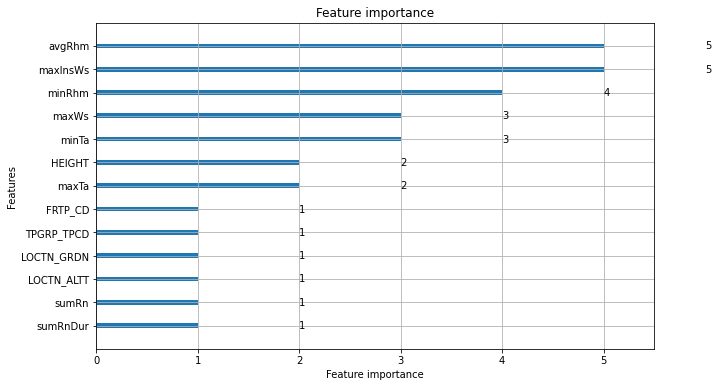

In [74]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_importance(lgb1, ax = ax)

In [75]:
lgb1_pred = lgb1.predict(X_test)
metrics(y_test, lgb1_pred)

정확도 : 1.00, 정밀도 : 0.27, 재현율 : 0.29
f1-score : 0.28, auc : 0.64


### 하이퍼 파라미터 튜닝 후 예측

In [ ]:
lgb = LGBMClassifier()

lgb_param_grid = {
    'n_estimators' : [100, 200, 400, 500, 600],
    'learning_rate' : [0.01, 0.05, 0.1, 0.2],
    'max_depth' : [4,5,6, 10, 12],
}
# sklearn.metrics.SCORERS.keys()
lgb_grid = GridSearchCV(lgb, param_grid = lgb_param_grid, scoring="accuracy", n_jobs= 1, verbose = 1)
lgb_grid.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [ ]:
print("최고 평균 auc : {0:.4f}".format(lgb_grid.best_score_))
print("최고의 파라미터 : ", lgb_grid.best_params_)
print("최고 점수를 낸 파라미터를 가진 모형 : ", lgb_grid.best_estimator_)

In [ ]:
result = pd.DataFrame(lgb_grid.cv_results_)
result.sort_values(by=['rank_test_score'], inplace=True)

In [ ]:
result[['params', 'mean_test_score', 'rank_test_score']].head(10)

In [ ]:
import joblib

lgb1 = lgb_grid.best_estimator_
lgb1.fit(X_train, y_train)
joblib.dump(xgb1, './lgb_1v30_model_1day_yn.pkl')

['./xgb_1v30_model_1day_yn.pkl']

In [18]:
lgb1 = LGBMClassifier(n_estimators=200, learning_rate = 0.2, max_depth = 10)
evals = [(X_test, y_test)]
lgb1.fit(X_train, y_train, early_stopping_rounds = 100, eval_metric = "logloss", eval_set = evals, verbose = True)
lgb1_pred = lgb1.predict(X_test)
metrics(y_test, lgb1_pred)

[1]	valid_0's binary_logloss: 0.079449	valid_0's binary_logloss: 0.079449
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.0698653	valid_0's binary_logloss: 0.0698653
[3]	valid_0's binary_logloss: 0.0649439	valid_0's binary_logloss: 0.0649439
[4]	valid_0's binary_logloss: 0.0593974	valid_0's binary_logloss: 0.0593974
[5]	valid_0's binary_logloss: 0.055311	valid_0's binary_logloss: 0.055311
[6]	valid_0's binary_logloss: 0.0528806	valid_0's binary_logloss: 0.0528806
[7]	valid_0's binary_logloss: 0.0499792	valid_0's binary_logloss: 0.0499792
[8]	valid_0's binary_logloss: 0.047289	valid_0's binary_logloss: 0.047289
[9]	valid_0's binary_logloss: 0.0446751	valid_0's binary_logloss: 0.0446751
[10]	valid_0's binary_logloss: 0.0432404	valid_0's binary_logloss: 0.0432404
[11]	valid_0's binary_logloss: 0.0422318	valid_0's binary_logloss: 0.0422318
[12]	valid_0's binary_logloss: 0.0416483	valid_0's binary_logloss: 0.0416483
[13]	valid_0's binary_loglos

## 2일 후 예측

In [48]:
#분석을 위해 음수 값을 가지는 칼럼들을 제외하고 결측치를 0으로 대체한다.
select_df = raw_df[['maxTa','minTa','avgTa','EIGHT_AGL','mi10MaxRn', 'hr1MaxRn', 'sumRnDur', 'sumRn', 'maxInsWs', 'maxWs', 'avgWs','minRhm','avgRhm','n99Rn', 'PRRCK_LARG', 'PRRCK_MDDL','LOCTN_ALTT','LOCTN_GRDN','CLZN_CD','TPGRP_TPCD','PRDN_FOM_C','SLDPT_TPCD','SLANT_TYP','SCSTX_CD','SLTP_CD','STORUNST','FROR_CD','FRTP_CD','KOFTR_GROU','DMCLS_CD','AGCLS_CD','HEIGHT','2day_yn']]
cleaned_df_2 = select_df.fillna(0)

In [49]:
y = cleaned_df_2['2day_yn']
X = cleaned_df_2.drop('2day_yn', axis =1)

In [50]:
# 1: 50 비율
X_samp, y_samp = RandomUnderSampler(random_state=1024, ratio={1: 359, 0: 10770}).fit_sample(X, y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [51]:
X_train, X_test, y_train, y_test = train_test_split(X_samp, y_samp, test_size=0.25, shuffle=True, stratify=y_samp, random_state=1024)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (8346, 32)
X_test shape: (2783, 32)
y_train shape: (8346,)
y_test shape: (2783,)


In [52]:
lgb2= LGBMClassifier(n_estimators=200, learning_rate = 0.2, max_depth = 10)
evals = [(X_test, y_test)]
lgb2.fit(X_train, y_train, eval_metric = "logloss", eval_set = evals, verbose = 1)

[1]	valid_0's binary_logloss: 0.0752762	valid_0's binary_logloss: 0.0752762
[2]	valid_0's binary_logloss: 0.0681095	valid_0's binary_logloss: 0.0681095
[3]	valid_0's binary_logloss: 0.0611646	valid_0's binary_logloss: 0.0611646
[4]	valid_0's binary_logloss: 0.0569602	valid_0's binary_logloss: 0.0569602
[5]	valid_0's binary_logloss: 0.0531249	valid_0's binary_logloss: 0.0531249
[6]	valid_0's binary_logloss: 0.0491415	valid_0's binary_logloss: 0.0491415
[7]	valid_0's binary_logloss: 0.0461132	valid_0's binary_logloss: 0.0461132
[8]	valid_0's binary_logloss: 0.0436982	valid_0's binary_logloss: 0.0436982
[9]	valid_0's binary_logloss: 0.041904	valid_0's binary_logloss: 0.041904
[10]	valid_0's binary_logloss: 0.0405532	valid_0's binary_logloss: 0.0405532
[11]	valid_0's binary_logloss: 0.039301	valid_0's binary_logloss: 0.039301
[12]	valid_0's binary_logloss: 0.0382284	valid_0's binary_logloss: 0.0382284
[13]	valid_0's binary_logloss: 0.0371193	valid_0's binary_logloss: 0.0371193
[14]	valid_0

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.2, max_depth=10,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=200, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [55]:
lgb = LGBMClassifier()

lgb_param_grid = {
    'n_estimators' : [100, 200, 400, 500, 600],
    'learning_rate' : [0.01, 0.05, 0.1, 0.15, 0.2],
    'max_depth' : [4, 6, 8, 10, 12],
}
# sklearn.metrics.SCORERS.keys()
lgb_grid = GridSearchCV(lgb, param_grid = lgb_param_grid, scoring="roc_auc", n_jobs= 1, verbose = 1)
lgb_grid.fit(X_train, y_train)

Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 625 out of 625 | elapsed:  8.5min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='deprecated', n_jobs=1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
                      

In [59]:
print("최고 평균 auc : {0:.4f}".format(lgb_grid.best_score_))
print("최고의 파라미터 : ", lgb_grid.best_params_)
print("최고 점수를 낸 파라미터를 가진 모형 : ", lgb_grid.best_estimator_)

AttributeError: ignored

In [58]:
result = pd.DataFrame(lgb_grid.cv_results_)
result.sort_values(by=['rank_test_score'], inplace=True)

AttributeError: ignored

In [ ]:
result[['params', 'mean_test_score', 'rank_test_score']].head(10)

In [ ]:
import joblib

lgb2 = lgb_grid.best_estimator_
lgb2.fit(X_train, y_train)
joblib.dump(lgb2, './xgb_1v30_model_2day_yn.pkl')

In [ ]:
lgb2_pred = lgb2.predict(X_test)
metrics(y_test, lgb2_pred)

# Submission 실행

In [26]:
# Merged_data_file
Merged_2020 = pd.read_csv('/content/drive/MyDrive/A2W/merge_s_h_a20.csv')
# Test 검증 데이터셋
test_input = pd.read_csv('/content/drive/MyDrive/A2W/input.csv', encoding = 'cp949')

In [27]:
# 훈련된 모델로 결과 도출 : day1 함수
def day1_data_test(sgg, umd, date):    
    # sgg 데이터와 umd 데이터, date를 통한 추출
    text = sgg + ' ' + umd
    # specific 자체가 학습 돌린 결과 참고해서 input으로 만들어야 됨
    test_day1 = Merged_2020[Merged_2020['umd2'].str.contains(text.rstrip()) & Merged_2020['tm'].str.contains(date)]
    test_specific_day1 = test_day1[['maxTa','minTa','avgTa','EIGHT_AGL','mi10MaxRn', 'hr1MaxRn', 'sumRnDur', 'sumRn', 'maxInsWs', 
                                    'maxWs', 'avgWs','minRhm','avgRhm','n99Rn', 'PRRCK_LARG', 'PRRCK_MDDL','LOCTN_ALTT','LOCTN_GRDN',
                                    'CLZN_CD','TPGRP_TPCD','PRDN_FOM_C','SLDPT_TPCD','SLANT_TYP','SCSTX_CD','SLTP_CD','STORUNST','FROR_CD',
                                    'FRTP_CD','KOFTR_GROU','DMCLS_CD','AGCLS_CD','HEIGHT']]
    fillna_test_specific_day1 = test_specific_day1.fillna(0)
    model_pred = lgb1.predict(fillna_test_specific_day1.to_numpy())
    return model_pred

# 훈련된 모델로 결과 도출 : day2 함수
def day2_data_test(sgg, umd, date):    
    # sgg 데이터와 umd 데이터, date를 통한 추출
    text = sgg + ' ' + umd
    # specific 자체가 학습 돌린 결과 참고해서 input으로 만들어야 됨
    test_day2 = Merged_2020[Merged_2020['umd2'].str.contains(text.rstrip()) & Merged_2020['tm'].str.contains(date)]
    test_specific_day2 = test_day2[['maxTa','minTa','avgTa','EIGHT_AGL','mi10MaxRn', 'hr1MaxRn', 'sumRnDur', 'sumRn', 'maxInsWs',
                                    'maxWs', 'avgWs','minRhm','avgRhm','n99Rn', 'PRRCK_LARG', 'PRRCK_MDDL','LOCTN_ALTT','LOCTN_GRDN',
                                    'CLZN_CD','TPGRP_TPCD','PRDN_FOM_C','SLDPT_TPCD','SLANT_TYP','SCSTX_CD','SLTP_CD','STORUNST','FROR_CD',
                                    'FRTP_CD','KOFTR_GROU','DMCLS_CD','AGCLS_CD','HEIGHT']]
    fillna_test_specific_day2 = test_specific_day2.fillna(0)
    model_pred = lgb2.predict(fillna_test_specific_day2.to_numpy())
    return model_pred

In [28]:
length_test_input = len(test_input.index)

#day_1 data
for index in range(length_test_input):
    if test_input['umd'][index] == "삼거동":
        input_date = test_input['date'][index]
        input_sgg = test_input['sgg'][index]
        input_umd = "상문동"
    elif test_input['umd'][index] == "어곡동":
        input_date = test_input['date'][index]
        input_sgg = test_input['sgg'][index]
        input_umd = "강서동"
    elif test_input['umd'][index] == "주진동":
        input_date = test_input['date'][index]
        input_sgg = test_input['sgg'][index]
        input_umd = "소주동"
    elif test_input['umd'][index] == "시동":
        input_date = test_input['date'][index]
        input_sgg = test_input['sgg'][index]
        input_umd = "불국동"
    elif test_input['umd'][index] == "덕곡동":
        input_date = test_input['date'][index]
        input_sgg = test_input['sgg'][index]
        input_umd = "지좌동"
    elif test_input['umd'][index] == "조와동":
        input_date = test_input['date'][index]
        input_sgg = test_input['sgg'][index]
        input_umd = "상망동"
    else:
        input_date = test_input['date'][index]
        input_sgg = test_input['sgg'][index]
        input_umd = test_input['umd'][index]
    test_input['1day_yn'][index] = day1_data_test(input_sgg, input_umd, input_date)
        

#day_2 data
for index in range(length_test_input):
    if test_input['umd'][index] == "삼거동":
        input_date = test_input['date'][index]
        input_sgg = test_input['sgg'][index]
        input_umd = "상문동"
    elif test_input['umd'][index] == "어곡동":
        input_date = test_input['date'][index]
        input_sgg = test_input['sgg'][index]
        input_umd = "강서동"
    elif test_input['umd'][index] == "주진동":
        input_date = test_input['date'][index]
        input_sgg = test_input['sgg'][index]
        input_umd = "소주동"
    elif test_input['umd'][index] == "시동":
        input_date = test_input['date'][index]
        input_sgg = test_input['sgg'][index]
        input_umd = "불국동"
    elif test_input['umd'][index] == "덕곡동":
        input_date = test_input['date'][index]
        input_sgg = test_input['sgg'][index]
        input_umd = "지좌동"
    elif test_input['umd'][index] == "조와동":
        input_date = test_input['date'][index]
        input_sgg = test_input['sgg'][index]
        input_umd = "상망동"
    else:
        input_date = test_input['date'][index]
        input_sgg = test_input['sgg'][index]
        input_umd = test_input['umd'][index]
    test_input['2day_yn'][index] = day2_data_test(input_sgg, input_umd, input_date)


test_input.head()

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: SettingWith

,date,sd,sgg,umd,1day,1day_yn,2day,2day_yn
0,2020-06-10,경상남도,사천시,곤명면,2020-06-11,0.0,2020-06-12,0.0
1,2020-06-11,경상남도,사천시,곤명면,2020-06-12,0.0,2020-06-13,0.0
2,2020-06-12,경상남도,사천시,곤명면,2020-06-13,0.0,2020-06-14,0.0
3,2020-06-10,경상남도,사천시,곤양면,2020-06-11,0.0,2020-06-12,0.0
4,2020-06-11,경상남도,사천시,곤양면,2020-06-12,0.0,2020-06-13,0.0


In [29]:
test_input["1day_yn"].value_counts()

0.0    3328
1.0      82
Name: 1day_yn, dtype: int64

In [30]:
test_input["2day_yn"].value_counts()

0.0    3410
Name: 2day_yn, dtype: int64

In [ ]:
test_input.to_csv("lgb_1v30_model.csv", index=False, encoding='cp949')